<a href="https://colab.research.google.com/github/Yarrieta/PROBABILIDAD_Y_ESTADISTICA_IA/blob/examen_final/hypothesis_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen final Probabilidad y Estadística para Inteligencia Artificial

Siguiendo con la historia de Don Francisco, con el tiempo y gracias a los análisis de Matı́as, el pequeño comerciante de
barrio cuenta hoy con 5 supermercados: ’Santa Ana’, ’La Floresta’, ’Los Cedros’, ’Palermo’ y ’Córdoba’.
También Matı́as ha avanzado en la Especialización en Inteligencia Artificial. Un dı́a Don Francisco le plantea algunas
inquietudes adicionales:
1. Don Francisco quiere entender mejor las ventas por mes del supermercado ’Santa Ana’.
2. Más aún, Don Francisco no sabe si puede estar seguro de que las ventas son las mismas en todos los supermercados o si
hay alguno que se comporte mejor que los demás, y si alguna de las tiendas necesita más atención porque sus ventas sean
peores que las de las otras.
3. Don Francisco tiene 5 clientes a los que les ha vendido mercancı́as a crédito y, de ellos, 1 están en mora con el pago prometido.
Matı́as, teniendo en cuenta la información disponible, considera que puede modelar el porcentaje p de morosidad según una
distribución B(1, 2). Para determinar los parámetros α y β, decide usar inferencia bayesiana. Con esto, pretende explicarle
a Don Francisco, cómo será el comportamiento de pago de sus clientes a crédito.

In [252]:
from google.colab import drive
from scipy import stats

In [253]:
!pip install pingouin

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from statsmodels.graphics.factorplots import interaction_plot

In [255]:
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [256]:
# Importar librerias
import pandas as pd

In [257]:
# Supermercado Córdoba
df_corboda = pd.read_csv("/content/drive/MyDrive/examen-final-PEIA/supermercado_cordoba.xlsx - corboda.csv")
df_corboda["Fecha"] = pd.to_datetime(df_corboda["Fecha"], format="%d/%m/%Y")
#df_corboda.set_index("Fecha", inplace=True)
df_corboda= df_corboda.replace(",", ".", regex=True)
print("Cantidad total de registros:", len(df_corboda))
df_corboda.head()

Cantidad total de registros: 365


,Fecha,Ventas
0,2023-01-01,9436.599034
1,2023-01-02,15154.67938
2,2023-01-03,15532.2756
3,2023-01-04,14599.19878
4,2023-01-05,20701.01319


In [258]:
# Supermercado La Floresta
df_la_floresta = pd.read_csv("/content/drive/MyDrive/examen-final-PEIA/supermercado_la_floresta.xlsx - la_floresta.csv")
df_la_floresta["Fecha"] = pd.to_datetime(df_la_floresta["Fecha"], format="%d/%m/%Y")
#df_la_floresta.set_index("Fecha", inplace=True)
df_la_floresta= df_la_floresta.replace(",", ".", regex=True)
print("Cantidad total de registros:", len(df_la_floresta))
df_la_floresta.head()

Cantidad total de registros: 365


,Fecha,Ventas
0,2023-01-01,14528.04302
1,2023-01-02,15616.72012
2,2023-01-03,22447.34418
3,2023-01-04,20440.80662
4,2023-01-05,21053.45924


In [259]:
# Supermercado Los Cedros
df_los_cedros = pd.read_csv("/content/drive/MyDrive/examen-final-PEIA/supermercado_los_cedros.xlsx - los_cedros.csv")
df_los_cedros["Fecha"] = pd.to_datetime(df_los_cedros["Fecha"], format="%d/%m/%Y")
#df_los_cedros.set_index("Fecha", inplace=True)
df_los_cedros= df_los_cedros.replace(",", ".", regex=True)
print("Cantidad total de registros:",len(df_los_cedros))
df_los_cedros.head()

Cantidad total de registros: 365


,Fecha,Ventas
0,2023-01-01,10039.6415
1,2023-01-02,14284.06338
2,2023-01-03,10592.77961
3,2023-01-04,15332.96389
4,2023-01-05,15360.58419


In [260]:
# Supermercado Palermo
df_palermo = pd.read_csv("/content/drive/MyDrive/examen-final-PEIA/supermercado_palermo.xlsx - palermo.csv")
df_palermo["Fecha"] = pd.to_datetime(df_palermo["Fecha"], format="%d/%m/%Y")
#df_palermo.set_index("Fecha", inplace=True)
df_palermo= df_palermo.replace(",", ".", regex=True)
print("Cantidad total de registros:",len(df_palermo))
df_palermo.head()

Cantidad total de registros: 365


,Fecha,Ventas
0,2023-01-01,15363.29967
1,2023-01-02,14631.65363
2,2023-01-03,17576.4515
3,2023-01-04,17158.66839
4,2023-01-05,15260.22582


In [261]:
# Supermercado Santa Ana
df_santa_ana = pd.read_csv("/content/drive/MyDrive/examen-final-PEIA/Datos_examen_final_17Co2024_Grupo9.xlsx - Santa Ana.csv")
df_santa_ana["Fecha"] = pd.to_datetime(df_santa_ana["Fecha"])
#df_santa_ana.set_index("Fecha", inplace=True)
print("Cantidad total de registros:",len(df_santa_ana))
df_santa_ana.head()

Cantidad total de registros: 365


,Fecha,Ventas
0,2023-01-01,13915.65363
1,2023-01-02,16713.74951
2,2023-01-03,17415.85259
3,2023-01-04,19494.02393
4,2023-01-05,22818.79946


1. Determinen intervalos de confianza empı́ricos para el supermercado ’Santa Ana’ en cada mes, para signifi-
cancias del 95 % y el 99 %.

In [262]:
df_santa_ana1 = pd.read_csv("/content/drive/MyDrive/examen-final-PEIA/Datos_examen_final_17Co2024_Grupo9.xlsx - Santa Ana.csv")
df_santa_ana1["Fecha"] = pd.to_datetime(df_santa_ana1["Fecha"])
df_santa_ana1.set_index("Fecha", inplace=True)
df_santa_ana1.head()

,Ventas
Fecha,
2023-01-01,13915.65363
2023-01-02,16713.74951
2023-01-03,17415.85259
2023-01-04,19494.02393
2023-01-05,22818.79946


,month,mean,std_dev,95%,99.7%
0,January,17080.033021,2691.991701,"(11696.049618889587, 22464.016423691064)","(9004.057917689217, 25156.008124891432)"
1,February,19161.388438,3370.833041,"(12419.722354589092, 25903.05452041091)","(9048.889313133635, 29273.887561866366)"
2,March,21986.340047,2631.834274,"(16722.67149790814, 27250.00859564023)","(14090.837223475119, 29881.84287007325)"
3,April,20059.823372,2543.818975,"(14972.185421952898, 25147.4613220471)","(12428.366446929349, 27691.280297070647)"
4,May,21220.437810,2385.686775,"(16449.064260012776, 25991.811359342064)","(14063.377485180452, 28377.498134174388)"
5,June,22295.229575,2585.169159,"(17124.891257859104, 27465.567892140898)","(14539.722099288654, 30050.73705071135)"
6,July,20858.711828,2624.624809,"(15609.462210415935, 26107.961446358262)","(12984.837401430355, 28732.586255343842)"
7,August,21951.956076,2809.589937,"(16332.77620214385, 27571.13595011421)","(13523.18626515126, 30380.7258871068)"
8,September,22908.471373,2727.945127,"(17452.581118966584, 28364.361627033424)","(14724.635991949872, 31092.306754050136)"
9,October,22174.217918,2623.927731,"(16926.36245626671, 27422.073379862326)","(14302.434725367802, 30046.001110761234)"


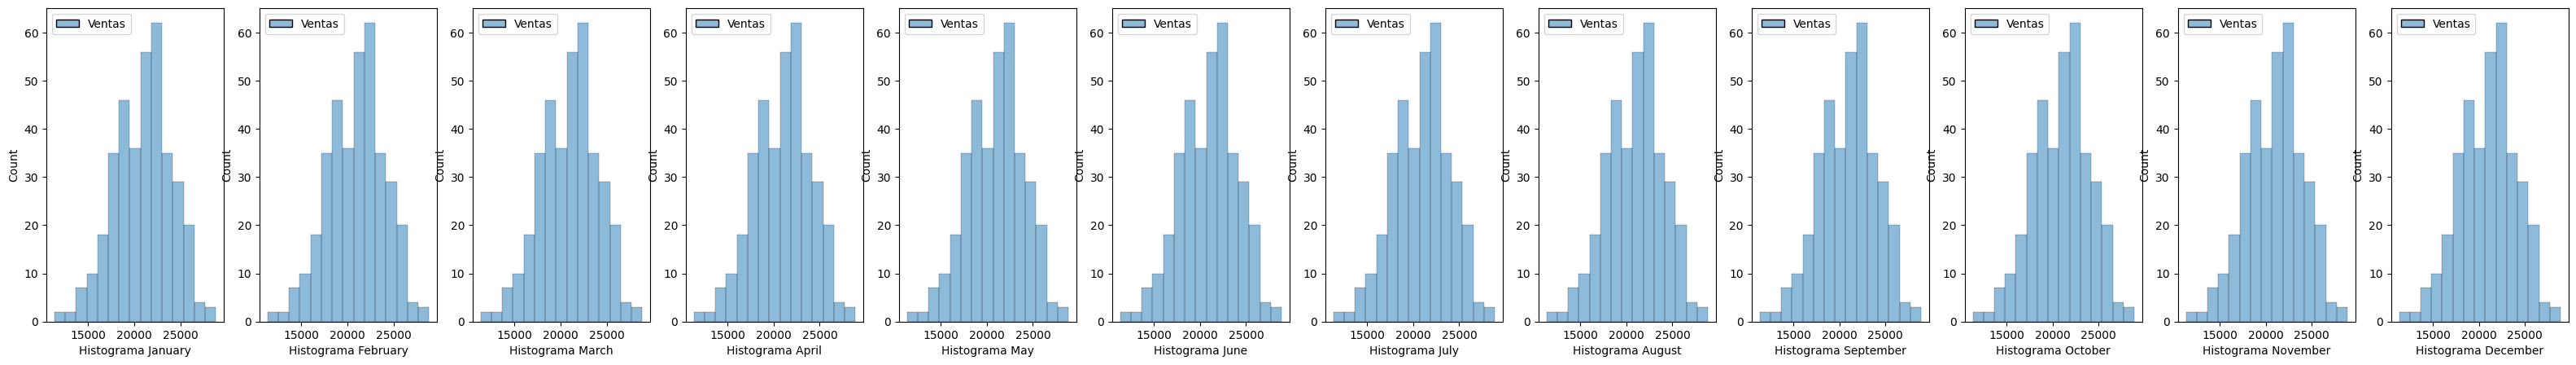

In [263]:
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

NUMBER_OF_MONTHS = 12

ci_empiric = {
    "month": [],
    "mean": [],
    "std_dev": [],
    "95%": [],
    "99.7%": []
}

df_santa_ana_by_month = []

fig, axs = plt.subplots(nrows=1, ncols=NUMBER_OF_MONTHS)
for i in range(NUMBER_OF_MONTHS):
    month_data = df_santa_ana1["Ventas"].iloc[df_santa_ana1.index.month == i+1]
    ci_empiric["month"].append(calendar.month_name[i+1])
    month_mean = month_data.mean()
    month_std = month_data.std()
    ci_empiric["mean"].append(month_mean)
    ci_empiric["std_dev"].append(month_std)
    ci_empiric["95%"].append((month_mean - 2*month_std, month_mean + 2*month_std))
    ci_empiric["99.7%"].append((month_mean - 3*month_std, month_mean + 3*month_std))
    sns.histplot(data=df_santa_ana1, ax=axs[i])
    axs[i].set_xlabel("Histograma " + calendar.month_name[i+1])
    df_santa_ana_by_month.append(month_data)

ci_empiric_df_santa_ana = pd.DataFrame.from_dict(ci_empiric)
display(ci_empiric_df_santa_ana)
fig.set_size_inches(40, 5)

2. Realicen pruebas ANOVA para determinar si las ventas esperadas de todas las tiendas son iguales o no,
con significancia del 95

In [264]:
# Añadir la columna 'Tienda' a cada DataFrame
df_santa_ana['Tienda'] = 'Santa Ana'
df_la_floresta['Tienda'] = 'La Floresta'
df_los_cedros['Tienda'] = 'Los Cedros'
df_palermo['Tienda'] = 'Palermo'
df_corboda['Tienda'] = 'Córdoba'

# Combinar todos los DataFrames en uno solo
data_combined = pd.concat([df_santa_ana, df_la_floresta, df_los_cedros, df_palermo, df_corboda])

# Mostrar las primeras filas del DataFrame combinado
data_combined.head()

,Fecha,Ventas,Tienda
0,2023-01-01,13915.65363,Santa Ana
1,2023-01-02,16713.74951,Santa Ana
2,2023-01-03,17415.85259,Santa Ana
3,2023-01-04,19494.02393,Santa Ana
4,2023-01-05,22818.79946,Santa Ana


In [265]:
df_santa_ana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   365 non-null    datetime64[ns]
 1   Ventas  365 non-null    float64       
 2   Tienda  365 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.7+ KB


In [266]:
df_la_floresta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   365 non-null    datetime64[ns]
 1   Ventas  365 non-null    object        
 2   Tienda  365 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.7+ KB


In [267]:
df_los_cedros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   365 non-null    datetime64[ns]
 1   Ventas  365 non-null    object        
 2   Tienda  365 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.7+ KB


In [268]:
df_palermo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   365 non-null    datetime64[ns]
 1   Ventas  365 non-null    object        
 2   Tienda  365 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.7+ KB


In [269]:
df_corboda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   365 non-null    datetime64[ns]
 1   Ventas  365 non-null    object        
 2   Tienda  365 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.7+ KB


In [270]:
# Cambio de dato de string a float de la variable Ventas
df_la_floresta['Ventas'] = df_la_floresta['Ventas'].astype('float')
df_los_cedros['Ventas'] = df_los_cedros['Ventas'].astype('float')
df_palermo['Ventas'] = df_palermo['Ventas'].astype('float')
df_corboda['Ventas'] = df_corboda['Ventas'].astype('float')

In [271]:
df_corboda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   365 non-null    datetime64[ns]
 1   Ventas  365 non-null    float64       
 2   Tienda  365 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.7+ KB


In [272]:
# Añadir la columna 'Tienda' a cada DataFrame
df_santa_ana['Tienda'] = 'Santa Ana'
df_la_floresta['Tienda'] = 'La Floresta'
df_los_cedros['Tienda'] = 'Los Cedros'
df_palermo['Tienda'] = 'Palermo'
df_corboda['Tienda'] = 'Córdoba'

# Combinar todos los DataFrames en uno solo
data_combined = pd.concat([df_santa_ana, df_la_floresta, df_los_cedros, df_palermo, df_corboda])

# Convertir la columna 'Ventas' a tipo numérico
#data_combined['Ventas'] = data_combined['Ventas'], errors='coerce')

# Mostrar las primeras filas del DataFrame combinado
data_combined.head()

,Fecha,Ventas,Tienda
0,2023-01-01,13915.65363,Santa Ana
1,2023-01-02,16713.74951,Santa Ana
2,2023-01-03,17415.85259,Santa Ana
3,2023-01-04,19494.02393,Santa Ana
4,2023-01-05,22818.79946,Santa Ana


In [273]:
#from google.colab import files  # Solo si estás en Google Colab
#data_combined.to_csv('supermercados.csv', index=False)
#files.download('supermercados.csv')


In [274]:
# Realizar la prueba ANOVA
# Agrupar los datos por tienda
"""ventas_por_tienda = [data_combined[data_combined['Tienda'] == tienda]['Tienda'] for tienda in data_combined['Tienda'].unique()]
ventas_por_tienda= pd.DataFrame.from_dict(ventas_por_tienda)

# Realizar la prueba ANOVA
anova_result = stats.f_oneway(*data_combined)

# Mostrar los resultados
print('F-valor:', anova_result.statistic)
print('p-valor:', anova_result.pvalue)

# Interpretar el resultado
if anova_result.pvalue < 0.05:
    print("Hay diferencias significativas en las ventas esperadas entre las tiendas (rechazamos H0).")
else:
    print("No hay diferencias significativas en las ventas esperadas entre las tiendas (no rechazamos H0).")
"""

'ventas_por_tienda = [data_combined[data_combined[\'Tienda\'] == tienda][\'Tienda\'] for tienda in data_combined[\'Tienda\'].unique()]\nventas_por_tienda= pd.DataFrame.from_dict(ventas_por_tienda)\n\n# Realizar la prueba ANOVA\nanova_result = stats.f_oneway(*data_combined)\n\n# Mostrar los resultados\nprint(\'F-valor:\', anova_result.statistic)\nprint(\'p-valor:\', anova_result.pvalue)\n\n# Interpretar el resultado\nif anova_result.pvalue < 0.05:\n    print("Hay diferencias significativas en las ventas esperadas entre las tiendas (rechazamos H0).")\nelse:\n    print("No hay diferencias significativas en las ventas esperadas entre las tiendas (no rechazamos H0).")\n'

In [275]:
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   1825 non-null   datetime64[ns]
 1   Ventas  1825 non-null   float64       
 2   Tienda  1825 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 57.0+ KB


In [276]:
data_combined.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Fecha,Ventas
count,1825.00,1825.00
mean,.2f,19892.06
min,.2f,9436.60
25%,.2f,17539.29
50%,.2f,20052.33
75%,.2f,22360.51
max,.2f,28860.14
std,nan,3412.03


In [277]:
# Número de observaciones por grupo
# ==============================================================================
data_combined.groupby('Tienda').size()

,0
Tienda,
Córdoba,365
La Floresta,365
Los Cedros,365
Palermo,365
Santa Ana,365


In [278]:
# Média y desviación típica por grupo
# ==============================================================================
data_combined.groupby('Tienda').agg(['mean', 'std'])

Fecha                                    Ventas             
                  mean                         std          mean          std
Tienda                                                                       
Córdoba     2023-07-02 105 days 12:15:21.280456948  17900.271075  2989.198032
La Floresta 2023-07-02 105 days 12:15:21.280456948  21713.716026  3063.659636
Los Cedros  2023-07-02 105 days 12:15:21.280456948  18068.391082  3068.290166
Palermo     2023-07-02 105 days 12:15:21.280456948  20787.278462  2908.004697
Santa Ana   2023-07-02 105 days 12:15:21.280456948  20990.659056  3080.749475

In [300]:
# Agrupar las ventas por supermercados
ventas_agrupadas = data_combined.groupby('Tienda')['Ventas'].sum().reset_index()

In [280]:
type(ventas_agrupadas)

pandas.core.frame.DataFrame

In [281]:
ventas_agrupadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tienda  5 non-null      object 
 1   Ventas  5 non-null      float64
dtypes: float64(1), object(1)
memory usage: 208.0+ bytes


In [301]:
ventas_agrupadas.head()

,Tienda,Ventas
0,Córdoba,6.533599e+06
1,La Floresta,7.925506e+06
2,Los Cedros,6.594963e+06
3,Palermo,7.587357e+06
4,Santa Ana,7.661591e+06


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 26.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 24.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 27.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 26.0% of the points cannot be plac

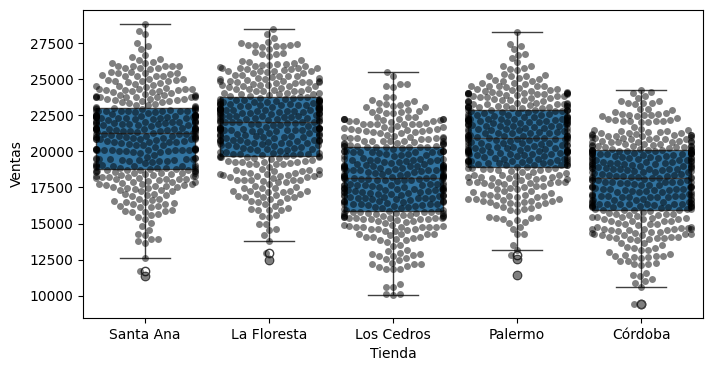

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x="Tienda", y="Ventas", data=data_combined, ax=ax)
sns.swarmplot(x="Tienda", y="Ventas", data=data_combined, color='black', alpha = 0.5, ax=ax);

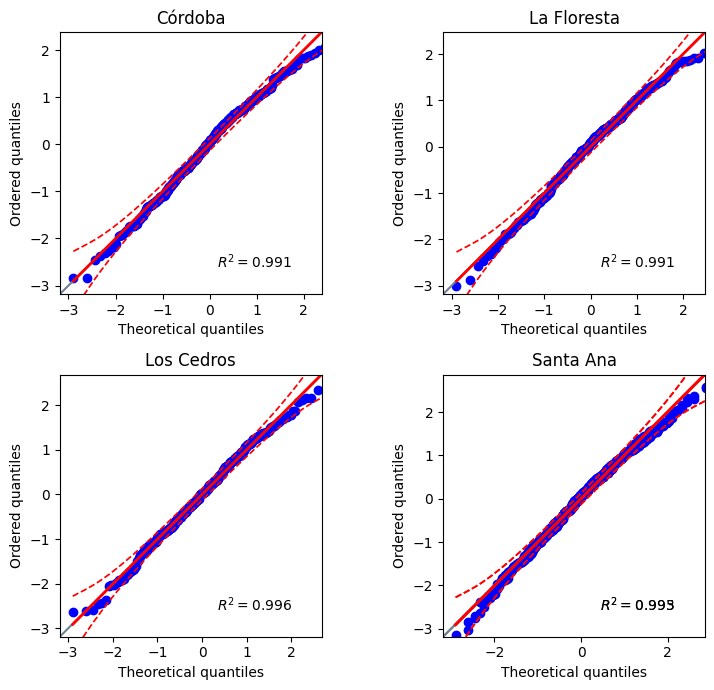

In [283]:
# Gráficos qqplot
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
pg.qqplot(data_combined.loc[data_combined.Tienda=='Córdoba', 'Ventas'], dist='norm', ax=axs[0,0])
axs[0,0].set_title('Córdoba')
pg.qqplot(data_combined.loc[data_combined.Tienda=='La Floresta', 'Ventas'], dist='norm', ax=axs[0,1])
axs[0,1].set_title('La Floresta')
pg.qqplot(data_combined.loc[data_combined.Tienda=='Los Cedros', 'Ventas'], dist='norm', ax=axs[1,0])
axs[1,0].set_title('Los Cedros')
pg.qqplot(data_combined.loc[data_combined.Tienda=='Palermo', 'Ventas'], dist='norm', ax=axs[1,1])
axs[1,1].set_title('Palermo')
pg.qqplot(data_combined.loc[data_combined.Tienda=='Santa Ana', 'Ventas'], dist='norm', ax=axs[1,1])
axs[1,1].set_title('Santa Ana')
plt.tight_layout()

In [284]:
# Test de normalidad Shapiro-Wilk
# ==============================================================================
pg.normality(data=data_combined, dv='Ventas', group='Tienda', method='shapiro')

,W,pval,normal
Tienda,,,
Santa Ana,0.994215,0.181755,True
La Floresta,0.990071,0.014315,False
Los Cedros,0.994128,0.172600,True
Palermo,0.992584,0.067192,True
Córdoba,0.989580,0.010641,False


In [285]:
# Test de homocedasticidad
# ==============================================================================
pg.homoscedasticity(data=data_combined, dv='Ventas', group='Tienda', method='levene')

,W,pval,equal_var
levene,0.358107,0.838501,True


In [286]:
# TEST DE ANOVA
# Test ANOVA de dos vías (Two-way ANOVA)
# ==============================================================================
#pg.anova(
#    data     = data_combined,
#    dv       = 'Ventas',
#    between  = ['Córdoba', 'La Floresta', 'Los Cedros', 'Palermo', 'Santa Ana'],
#    detailed = True
#).round(4)

# Test ANOVA de dos vías (Two-way ANOVA)
# ==============================================================================
#pg.rm_anova(
#    data       = data_combined,
#    dv         = 'Ventas',
#    within     = 'Tienda',
#    subject    = 'Fecha',
#    detailed   = True,
#    correction = 'auto'
#).round(4)
pg.anova(data=data_combined, dv='Ventas', between='Tienda', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,Tienda,4.606212e+09,4,1.151553e+09,126.036728,4.598727e-95,0.216917
1,Within,1.662870e+10,1820,9.136646e+06,NaN,NaN,NaN


In [287]:
data_combined

,Fecha,Ventas,Tienda
0,2023-01-01,13915.65363,Santa Ana
1,2023-01-02,16713.74951,Santa Ana
2,2023-01-03,17415.85259,Santa Ana
3,2023-01-04,19494.02393,Santa Ana
4,2023-01-05,22818.79946,Santa Ana
...,...,...,...
360,2023-12-27,19079.16237,Córdoba
361,2023-12-28,21212.07381,Córdoba
362,2023-12-29,19921.40255,Córdoba
363,2023-12-30,13679.38231,Córdoba


In [288]:
!pip install researchpy

In [289]:
import researchpy as rp

In [290]:
rp.summary_cont(data_combined['Ventas'].groupby(data_combined['Tienda']))

,N,Mean,SD,SE,95% Conf.,Interval
Tienda,,,,,,
Córdoba,365,17900.2711,2989.1980,156.4618,17592.5886,18207.9536
La Floresta,365,21713.7160,3063.6596,160.3593,21398.3691,22029.0630
Los Cedros,365,18068.3911,3068.2902,160.6016,17752.5675,18384.2146
Palermo,365,20787.2785,2908.0047,152.2119,20487.9533,21086.6036
Santa Ana,365,20990.6591,3080.7495,161.2538,20673.5530,21307.7651


In [291]:
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm # Import anova_lm directly

# Fit the ANOVA model
model = sm.ols('Ventas ~ Tienda', data=data_combined).fit()

# Perform the ANOVA test
anova_result = anova_lm(model, typ=2)

# Display the results
print(anova_result)

                sum_sq      df           F        PR(>F)
Tienda    4.606212e+09     4.0  126.036728  4.598727e-95
Residual  1.662870e+10  1820.0         NaN           NaN


In [302]:
ventas_agrupadas.head()

,Tienda,Ventas
0,Córdoba,6.533599e+06
1,La Floresta,7.925506e+06
2,Los Cedros,6.594963e+06
3,Palermo,7.587357e+06
4,Santa Ana,7.661591e+06


In [303]:
# Realizar la prueba ANOVA
# Agrupar los datos por tienda
#ventas_por_tienda = [data_combined[data_combined['Tienda'] == tienda]['Ventas'] for tienda in data_combined['Tienda'].unique()]
#ventas_por_tienda= pd.DataFrame.from_dict(ventas_por_tienda)
import scipy.stats as stats # Import the correct module for f_oneway

# Realizar la prueba ANOVA#
#anova_result = stats.f_oneway(*data_combined)

"""anova_result =(data_combined['Ventas'][data_combined['Tienda'] == 'Santa Ana'],
               data_combined['Ventas'][data_combined['Tienda'] == 'La Floresta'],
               data_combined['Ventas'][data_combined['Tienda'] == 'Los Cedros'],
               data_combined['Ventas'][data_combined['Tienda'] == 'Palermo'],
               data_combined['Ventas'][data_combined['Tienda'] == 'Córdoba'])"""

# Realizar la prueba ANOVA
anova_result = stats.f_oneway(*ventas_agrupadas)

# Mostrar los resultados
print('F-valor:', anova_result.statistic)
#print('p-valor:', anova_result.pvalue)

# Interpretar el resultado
#if anova_result.pvalue < 0.05:
#    print("Hay diferencias significativas en las ventas esperadas entre las tiendas (rechazamos H0).")
#else:
#    print("No hay diferencias significativas en las ventas esperadas entre las tiendas (no rechazamos H0).")
anova_result

F-valor: nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if _f_oneway_is_too_small(samples):


F_onewayResult(statistic='nan', pvalue='nan')

3. Identifiquen la tienda con mayor promedio de ventas y la tienda con menor promedio de ventas y realicen
una prueba de hipótesis para determinar si la diferencia entre ellas es distinta de cero o no.

In [294]:
import numpy as np

max_idx = ci_empiric_df_santa_ana["mean"].idxmax()
min_idx = ci_empiric_df_santa_ana["mean"].idxmin()

max_mean_sales_month = ci_empiric_df_santa_ana["month"].iloc[max_idx]
min_mean_sales_month = ci_empiric_df_santa_ana["month"].iloc[min_idx]

print("Max mena sales month: ", max_mean_sales_month)
print("Min mean sales month: ", min_mean_sales_month)

max_min_mean_sales = np.concatenate((df_santa_ana_by_month[max_idx].to_numpy(), df_santa_ana_by_month[min_idx].to_numpy()))

res = stats.ttest_1samp(max_min_mean_sales, df_santa_ana.mean())
print(res)
print("La media de las muestras se desvía",  res.statistic, "de la hipotesis nula.")

Max mena sales month:  September
Min mean sales month:  January


TypeError: Could not convert ['Santa AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta AnaSanta Ana'] to numeric

### Bibliografía


https://cienciadedatos.net/documentos/pystats09-analisis-de-varianza-anova-python